In [1]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Seaborn 套件是以 matplotlib 為基礎建構的高階繪圖套件，讓使用者更加輕鬆地建立圖表，我們可以將它視為是 matplotlib 的補強
%matplotlib inline #這個指令可以讓圖形不會在新視窗呈現

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
train = pd.read_csv("train.csv")
test =pd.read_csv("test.csv")
final = pd.read_csv("gender_submission.csv")

使用info()來觀察train 和test是否有空值

In [7]:
#train資料的Age, Cabin, Embarked有空值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
#test資料的Age, Fare, Cabin有空值
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
#使用describe來觀察資料型態
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


對整體資料做一些觀察，因此先將整體資料做合併

In [17]:
data = train.append(test) #合併會造成index重複問題
data.reset_index(inplace=True, drop= True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# 資料分析

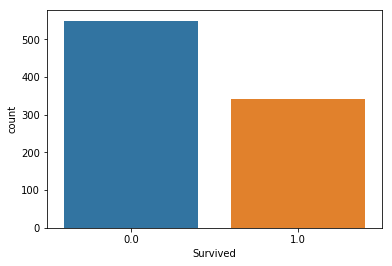

In [18]:
sns.countplot(data["Survived"])

發現死亡率大概是6成，生存率大概是4成

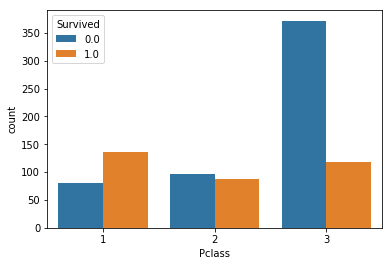

In [22]:
#觀察艙等跟生存率的關係
sns.countplot(data["Pclass"],hue=data["Survived"])

發現在艙等1的生存率最高，艙等3的生存率最低<br>
有此可推，在越高處的存活率機會越高

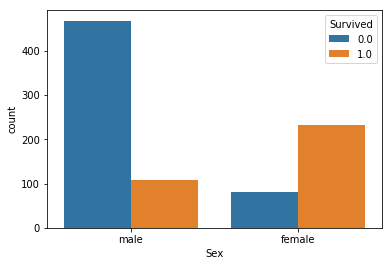

In [23]:
#觀察性別跟生存率的關係
sns.countplot(data["Sex"],hue=data["Survived"])

發現在女性的生存率較高，男性的生存率較低<br>
有此可推，救援資源應該是先禮讓給長者和女性

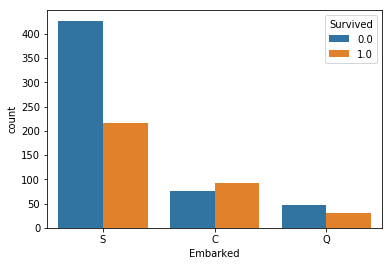

In [24]:
#觀察出港口跟生存率的關係
sns.countplot(data["Embarked"],hue=data["Survived"])

發現在由S城市出發的人死亡率最高<br>
有此可推，此城市出發的人可能都買到在艙等3的位子

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


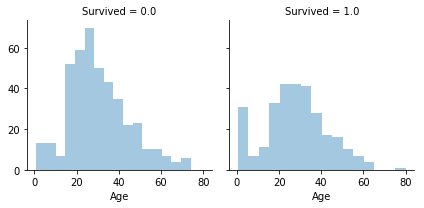

In [26]:
g = sns.FacetGrid(data,col="Survived") #Apply a plotting function to each facet’s subset of the data.
g.map(sns.distplot,"Age",kde=False)

發現在年齡越小，生存率越高<br>
有此可推，救援先以老弱婦孺優先

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


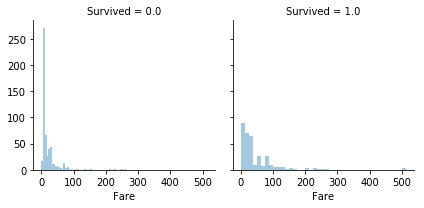

In [28]:
g = sns.FacetGrid(data,col="Survived")
g.map(sns.distplot,"Fare",kde=False)

觀察票價與生存率的關係<br>
發現購買票價越低的人，死亡人數越高

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


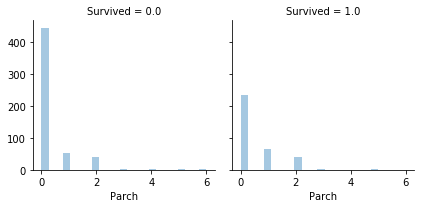

In [29]:
#觀察 父母＋小孩在一起的死亡率
g = sns.FacetGrid(data,col="Survived")
g.map(sns.distplot,"Parch",kde=False)

由此發現，父母＋小孩沒有再一起來的死亡人數較高

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


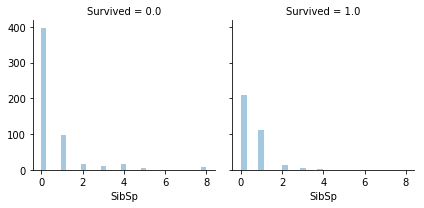

In [32]:
#觀察 兄弟姊妹＋配偶在一起的死亡率
g = sns.FacetGrid(data,col="Survived")
g.map(sns.distplot,"SibSp",kde=False)

由此發現，兄弟姊妹＋配偶沒有再一起來的死亡人數較高

把「父母＋小孩」和「兄弟姊妹＋配偶」變成一個新的欄位名稱，讓預測可更精準

In [35]:
data["Family"] = data["Parch"]+data["SibSp"]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


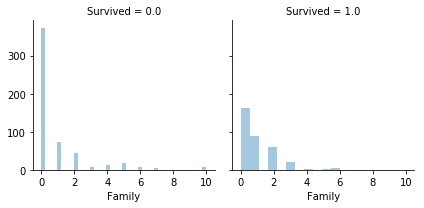

In [36]:
g = sns.FacetGrid(data,col="Survived")
g.map(sns.distplot,"Family",kde=False)

由此觀察，一個人搭乘的死亡率較高

# 特徵工程
從原始的數據轉換成向量的過程

### 整理Name資料

In [62]:
data['Title1'] = data["Name"].str.split(",",expand=True)[1]

In [63]:
data['Name'].str.split(",",expand=True).head(3)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina


In [64]:
data['Title1'].head(3)

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
Name: Title1, dtype: object

In [67]:
data['Title1'] = data["Title1"].str.split(".",expand=True)[0]

In [68]:
data['Title1'].head(3)

0       Mr
1      Mrs
2     Miss
Name: Title1, dtype: object

In [69]:
data["Title1"].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

### 將Name對性別、生存率和年齡做分析
根据一个或多个键对数据进行聚合，并根据行和列上得分组建将数据分配到各个矩形区域中。


In [71]:
pd.crosstab(data["Title1"],data["Sex"]).T.style.background_gradient(cmap="summer_r")

Title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [72]:
pd.crosstab(data["Title1"],data["Survived"]).T.style.background_gradient(cmap="summer_r")

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0.0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1.0,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


In [75]:
data.groupby(["Title1"])["Age"].mean()

Title1
 Capt            70.000000
 Col             54.000000
 Don             40.000000
 Dona            39.000000
 Dr              43.571429
 Jonkheer        38.000000
 Lady            48.000000
 Major           48.500000
 Master           5.482642
 Miss            21.774238
 Mlle            24.000000
 Mme             24.000000
 Mr              32.252151
 Mrs             36.994118
 Ms              28.000000
 Rev             41.250000
 Sir             49.000000
 the Countess    33.000000
Name: Age, dtype: float64

### 以下發現狀況
1.Master平均年齡為5歲，生存率達6成<br>
2.有些稱謂的乘客為極少數→若只將這些極少數的乘客做機器學習模型會非常不好，因此把其中一些稱為合併

In [90]:
data["Title2"] = data["Title1"].replace([' Capt',' Col',' Don',' Dona',' Dr',' Jonkheer',' Lady',' Major'," Mlle",' Mme',' Rev',' Sir',' the Countess'," Ms"],[' Mr',' Mr',' Mr',' Mr',' Mr',' Mr',' Miss',' Mr',' Mrs'," Mrs",' Mr',' Mr',' Mr',' Miss'])


In [91]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master'], dtype=object)

In [92]:
pd.crosstab(data["Title2"],data["Sex"]).T.style.background_gradient(cmap="summer_r")

Title2,Master,Miss,Mr,Mrs
Sex,,,,
female,0,263,3,200
male,61,0,782,0


In [93]:
pd.crosstab(data["Title2"],data["Survived"]).T.style.background_gradient(cmap="summer_r")

Title2,Master,Miss,Mr,Mrs
Survived,,,,
0.0,17,55,451,26
1.0,23,129,88,102


再來分析票號的資訊，相同的英文代碼可能代表房間的位置，後面的號碼沒有意義故省略，如果只有號碼的話用X來代替

In [149]:
data["Ticket_info"] = data["Ticket"].apply(lambda x :x.replace(".","").
                                           replace("/","").strip("").split(' ')[0] if not x.isdigit() else 'X')

In [150]:
data["Ticket_info"].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

登船港口(Embarked)只有遺漏少數，直接補上出現最多次的"S"，費用也只有遺漏一比，因此直接補上平均數

In [151]:
data["Embarked"] = data["Embarked"].fillna("S")

In [152]:
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())

觀察Cabin的資料後，Nan以NoCabin來表示

In [154]:
data['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [156]:
data["Cabin"] = data["Cabin"].apply(lambda x : str(x)[0] if not pd.isnull(x) else "NoCabin")

In [158]:
data["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

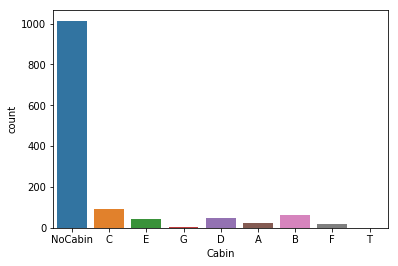

In [159]:
sns.countplot(data['Cabin'])

將資料轉為整數

In [160]:
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes

使用隨機森林來推測年齡

In [162]:
dataAgeNull = data[data["Age"].isnull()]
dataAgeNotNull = data[data["Age"].notnull()]
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["Family"]-dataAgeNotNull["Family"].mean())>(4*dataAgeNotNull["Family"].std()))                     
                     ]
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title1', 'Title2','Cabin','Ticket_info']
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [166]:
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

In [181]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]

載入隨機森林演算法（Random Forest)來預測存活率

In [169]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


In [190]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
4,Sex,0.266774
2,Fare,0.163736
6,Title2,0.150190
0,Age,0.132832
3,Pclass,0.091129
5,Family,0.070468
8,Cabin,0.067366
7,Ticket_info,0.031140
1,Embarked,0.026366


# Submit

In [194]:
rf_res =  rf.predict(dataTest)
final['Survived'] = rf_res
final['Survived'] = final['Survived'].astype(int)
final.to_csv('submit.csv', index= False)